# Batches!
- #### This project will examine batching, different techniques, and how batching is a form of data regularization.

In [338]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# importing iris dataset
import seaborn as sns
iris_dataset = sns.load_dataset('iris')

### Transforming and Loading Data

In [339]:
# converting from pandas dataframe to pytorch tensor
torched_iris_dataset= torch.tensor(iris_dataset[iris_dataset.columns[0:4]].values).float() # only use first 4 columns, because last column is outcome variable or datatype.

# numeric transformation - transforming species name to a number (0-2)
iris_labels = torch.zeros(len(torched_iris_dataset), dtype=torch.long) # species 'setosa' will remain 0.
iris_labels[iris_dataset.species=='versicolor'] = 1
iris_labels[iris_dataset.species=='virginica'] = 2

### What datasets do you partition into smaller batches?
- Typically the training dataset, which is what the model is learning from.
    - This is a form of regularization, because with each epoch the model is trained on different batches of new training data.
    - Overfitting is reduced, because the losses are averaged over multiple samples.
- If the test dataset is huge, then it may be practical to test the model in batches.
    - Otherwise, the size of the batch for the test set will be all of the samples in the test set.

### What do you do if the last batch isn't the same size as the rest of the batches?
- The `drop_last = True` parameter will drop the last batch from the data loader object.
- This will result in lost data! 
    - This doesn't matter if you have a large dataset, but for smaller datasets this can be detrimental.
- It may be worth exploring different batch sizes to mitigate the data lost in the last batch.

In [340]:
# splitting iris dataset into training and testing
train_data, test_data, train_labels, test_labels = train_test_split(torched_iris_dataset, iris_labels, train_size= 0.8)

# converting to torch tensors, grouping data and labels
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# creating data loaders
batch_size = 4
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

print("Set with last batch: ")
for X,y in train_loader:
    print(X.shape, y.shape) # torch.Size([16, 4]) torch.Size([16]), last batch is [8,4] [8]
print("\n")


train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True) # drops last batch if smaller than batch_size
print("Set without last batch dropped (if not == batch size): ")
for X,y in train_loader:
    print(X.shape, y.shape)
print("\n")

test_loader = DataLoader(test_data, shuffle=True, batch_size= test_data.tensors[0].shape[0]) # only batched if test dataset is large.

Set with last batch: 
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4]

### Creating and Training Model (not focus of this practice)

In [341]:
def create_ANN_model(learning_rate):
    
    # model architecture
    ANN_model = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
    )

    # loss function
    loss_function = nn.CrossEntropyLoss()

    # optimizer, this is where L2 penalty is applied
    optimizer = torch.optim.SGD(ANN_model.parameters(), lr=learning_rate)

    return ANN_model, loss_function, optimizer

In [342]:
def batch_train_model(number_of_epochs, ANN_iris, loss_function, optimizer):
    
    training_accuracy_ary = []
    testing_accuracy_ary = []
    losses_ary = []

    # loop over epochs
    for epoch_IDX in range(number_of_epochs):

        batch_accuracy = []
        batch_loss = []

        for batch, labels in train_loader:
        # forward pass and calculate loss
            y_hat = ANN_iris(batch)
            loss = loss_function(y_hat, labels)

            # backpropagation (learning)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate accuracy for current batch
            batch_accuracy.append(100*torch.mean((torch.argmax(y_hat, axis=1) == labels).float()).item())

            # batch losses
            batch_loss.append(loss.item())

        # calculate overall training accuracy and loss
        training_accuracy_ary.append(np.mean(batch_accuracy))
        losses_ary.append(np.mean(batch_loss))

        # Cross Validation of Model
        X_data, y_labels = next(iter(test_loader)) # there is only one batch, so there's no need for a for loop
        predicted_testing_labels = torch.argmax(ANN_iris(X_data),axis=1)

        # calculate testing accuracy
        testing_accuracy_ary.append(100*torch.mean((predicted_testing_labels == y_labels).float()).item())

    return training_accuracy_ary, testing_accuracy_ary, losses_ary

In [343]:
# model params
learning_rate = 0.0005
num_epochs = 1500

# creating and training model
ANN_iris, loss_function, optimizer = create_ANN_model(learning_rate)
training_acc, test_acc, losses = batch_train_model(num_epochs, ANN_iris, loss_function, optimizer)

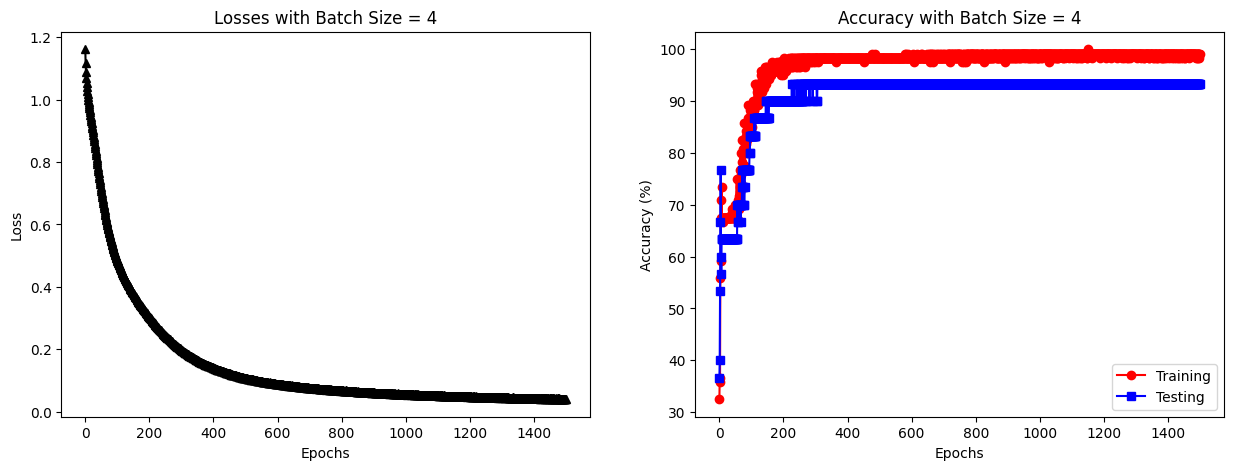

In [344]:
# plotting results
fig, ax = plt.subplots(1,2, figsize = (15,5))

# losses plot
ax[0].plot(losses, 'k^-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title(f'Losses with Batch Size = {batch_size}')

# accuracy plot
ax[1].plot(training_acc, 'ro-')
ax[1].plot(test_acc, 'bs-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Accuracy with Batch Size = {batch_size}')
ax[1].legend(['Training', 'Testing'])

#### Examining the Results:
- Note: This is a relatively homogenous dataset, where the data points are relatively similar to one another.
- For different batches sizes, there are different 'symptoms' that indicate if the model is doing well or poorly.
- The model performed the best with a learning rate at `0.0005`, batch sizes of `4`, and `1500` epochs.
- #### Smaller batch sizes seem to be associated with quicker learning for this model and dataset.
    - The dataset is small
    - The model is simple
    - Homogenous dataset - The data points are pretty similar.


- #### If the batches are too small, it looks like Stochastic Gradient Descent. 
    - Generally the model will train well, but not perform as well with the testing.
    - The learning can be more jagged / inconsistent.
    - Longer **computation time**, takes much longer to train.
    - **Overfitting** can reduce generalizability and testing performance.
    - You don't get the benefits of the data being regularized.

<br><br>
- ##### Note: Batch sizes around 30 for this model and dataset
    - Testing performance is often better than training performance. I don't know what is causing this for sure.
    - The learning speed is not consistent between runs. The model either learns very quickly, or runs into several asymptotes and 'gets stuck' with accuracy.
    - This makes me wonder if there is an optimal learning rate to use with certain batch sizes. That would be worth looking at later.
    - I changed the learning rate from `0.0005` to `0.005` and the model immediately trained better at the batch size.
    - Even after this change, the problem still appeared where the testing accuracy was higher than the training accuracy.

<br><br>
- #### This model struggles or even fails to learn when larger batch sizes (around 54) are used with the smaller learning rate.
    - This was with a learning rate of `0.0005`. Maybe this was too small?
    - Increased learning rate to `0.005` and it performed somewhat better and more consistently. Many problems were still present.
    - Increased learning rate to `0.05` and the model was not learning at all.
    - Not enough data to support the large batch sizes.
    - There is likely lots of data lost in the last batch if it is dropped.
    - The model gets 'stuck' at certain accuracies for many epochs.


- #### Key behaviors to look for when batch sizes are too large:  
    - The accuracy graph is very jagged.
    - There is a tendency for the testing to perform better than training accuracy.
    - The accuracy drops back down during training.
    - The accuracy hits asymptotes at lower accuracies and gets 'stuck' for long periods of training.
    - The accuracy is generally lower even by the end of training.
    - Increasing the number of epochs does not significantly improve the accuracy.
    - Results of training are very inconsistent between runs.